In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Загрузка данных

In [2]:
import os, zipfile, tarfile, requests
from urllib.parse import urlsplit, urlunsplit, quote, unquote
from tqdm import tqdm

os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/masks', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('data/raw', exist_ok=True)

URLS = [
    "https://zenodo.org/record/8265464/files/Diverse Fetal Head Images-orginal-image.zip",
    "https://zenodo.org/record/8265464/files/Trans-cerebellum-orginal-size.zip",
    "https://zenodo.org/record/8265464/files/Trans-thalamic-orginal-size.zip",
    "https://zenodo.org/record/8265464/files/Trans-ventricular-orginal-size.zip",
]

def _encode_url(u):
    p = urlsplit(u)
    path = quote(p.path)
    return urlunsplit((p.scheme, p.netloc, path, p.query, p.fragment))

def _download(url, dst_path):
    headers = {'User-Agent': 'Mozilla/5.0'}
    r = requests.get(url, stream=True, headers=headers, allow_redirects=True, timeout=60)
    r.raise_for_status()
    ct = r.headers.get('content-type', '')
    if not any(x in ct for x in ('application/zip', 'octet-stream', 'application/x-zip-compressed')):
        with open('data/download_debug.html', 'wb') as f:
            f.write(r.content)
        raise RuntimeError(f"Unexpected content-type: {ct}. Saved to data/download_debug.html")
    total = int(r.headers.get('content-length', 0)) or None
    with open(dst_path, 'wb') as f, tqdm(total=total, unit='iB', unit_scale=True, desc=os.path.basename(dst_path)) as bar:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if not chunk:
                continue
            f.write(chunk)
            if total:
                bar.update(len(chunk))

def _extract(archive_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if zipfile.is_zipfile(archive_path):
        with zipfile.ZipFile(archive_path, 'r') as z:
            z.extractall(extract_dir)
    elif tarfile.is_tarfile(archive_path):
        with tarfile.open(archive_path, 'r:*') as t:
            t.extractall(extract_dir)
    else:
        raise RuntimeError(f"Unknown archive format: {archive_path}")

def download_and_extract_all(urls):
    for u in urls:
        enc = _encode_url(u)
        fname = os.path.basename(unquote(urlsplit(enc).path))
        dst_zip = os.path.join('data', fname)
        out_dir = os.path.join('data', 'raw', os.path.splitext(fname)[0])

        if os.path.exists(dst_zip):
            print(f"[skip] already downloaded: {dst_zip}")
        else:
            print(f"[get] {u}")
            try:
                _download(enc, dst_zip)
                print(f"[ok] saved: {dst_zip}")
            except Exception as e:
                if os.path.exists(dst_zip):
                    os.remove(dst_zip)
                print(f"[fail] download error: {e}")
                continue

        if os.path.exists(out_dir) and any(os.scandir(out_dir)):
            print(f"[skip] already extracted: {out_dir}")
        else:
            try:
                print(f"[extract] -> {out_dir}")
                _extract(dst_zip, out_dir)
                print(f"[ok] extracted: {out_dir}")
            except Exception as e:
                print(f"[fail] extract error: {e}")

download_and_extract_all(URLS)

In [3]:
%pip -q install opencv-python==4.10.0.84 numpy matplotlib tqdm scikit-learn==1.5.2


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install albumentations==1.3.1 albucore==0.0.9

Looking in indexes: https://repository.avp.ru/artifactory/api/pypi/r-pip/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.33
    Uninstalling albucore-0.0.33:
      Successfully uninstalled albucore-0.0.33
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.14
    Uninstalling albumentations-1.4.14:
      Successfully uninstalled albumentations-1.4.14
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os, re, json, random, shutil, glob
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

SEED = 1337
random.seed(SEED); np.random.seed(SEED)

In [7]:
%pip -q install tqdm

import os, zipfile, shutil, re
from pathlib import Path
from urllib.parse import quote
import requests
from tqdm import tqdm

os.makedirs("data", exist_ok=True)
os.makedirs("data/raw", exist_ok=True)

ZENODO_BASE = "https://zenodo.org/record/8265464/files/"
ARCHIVES = [
    "Diverse Fetal Head Images.zip",
    "Trans-cerebellum.zip",
    "Trans-thalamic.zip",
    "Trans-ventricular.zip",
]

def download(url, dst):
    if Path(dst).exists():
        print(f"[skip] already downloaded: {dst}")
        return
    r = requests.get(url, stream=True, headers={"User-Agent":"Mozilla/5.0"})
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(dst, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=Path(dst).name) as pbar:
        for chunk in r.iter_content(1<<20):
            if chunk: f.write(chunk); pbar.update(len(chunk))
    print(f"[ok] saved: {dst}")

def extract_zip(zip_path, out_dir):
    out_dir = Path(out_dir)
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"[skip] already extracted: {out_dir}")
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path) as z:
        z.extractall(out_dir)
    print(f"[ok] extracted: {out_dir}")

for name in ARCHIVES:
    url = ZENODO_BASE + quote(name)
    dst = f"data/{name}"
    download(url, dst)
    extract_zip(dst, f"data/raw/{Path(name).stem}")


In [8]:
import zipfile, fnmatch

MASK_ROOT = Path("data/masks_flat")
if MASK_ROOT.exists():
    shutil.rmtree(MASK_ROOT)
MASK_ROOT.mkdir(parents=True, exist_ok=True)

MASK_SUBZIP_PATTERNS = ["*Segmentation mask*.zip", "*segmentation*.zip", "*mask*.zip"]

def extract_matching_subzips(folder_root: Path, dataset_tag: str):
    subzips = list(folder_root.rglob("*.zip"))
    subzips = [p for p in subzips if any(fnmatch.fnmatch(p.name.lower(), pat.lower()) for pat in MASK_SUBZIP_PATTERNS)]
    if not subzips:
        print(f"[warn] no mask sub-zips found under {folder_root}")
        return 0
    count = 0
    for zpath in subzips:
        with zipfile.ZipFile(zpath) as zf:
            for m in zf.infolist():
                if m.is_dir():
                    continue
                if not m.filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")):
                    continue
                base = Path(m.filename).name
                out = MASK_ROOT / f"{dataset_tag}__{base}"
                with zf.open(m) as src, open(out, "wb") as dst:
                    dst.write(src.read())
                count += 1
    return count

TOTAL_MASKS = 0
for ds in ["Diverse Fetal Head Images", "Trans-cerebellum", "Trans-thalamic", "Trans-ventricular"]:
    root = Path("data/raw") / ds
    TOTAL_MASKS += extract_matching_subzips(root, ds.replace(" ", "_"))

TOTAL_MASKS

7664

In [9]:
from pathlib import Path
import re

IMG_DIRS = [
    Path("data/raw/Diverse Fetal Head Images-orginal-image"),
    Path("data/raw/Trans-cerebellum-orginal-size"),
    Path("data/raw/Trans-thalamic-orginal-size"),
    Path("data/raw/Trans-ventricular-orginal-size"),
]
MASK_ROOT = Path("data/masks_flat")
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def img_key(name: str) -> str:
    s = name.lower()
    s = re.sub(r"\.(png|jpg|jpeg|tif|tiff|bmp)$", "", s)
    s = re.sub(r"-checkpoint$", "", s)
    return s

def mask_key(name: str) -> str:
    s = name.lower()
    s = re.sub(r"\.(png|jpg|jpeg|tif|tiff|bmp)$", "", s)
    # отрезаем префикс вида "<dataset>__"
    s = re.sub(r"^[a-z0-9_ \-]+__", "", s)
    return s

# 1) изображения (без *-checkpoint)
images = []
for d in IMG_DIRS:
    if not d.exists():
        continue
    for p in d.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS and not p.name.lower().endswith("-checkpoint.png"):
            images.append(p)

# 2) маски
masks = [p for p in MASK_ROOT.glob("*") if p.suffix.lower() in IMG_EXTS]

# 3) индексы
img_idx = {}
for p in images:
    img_idx.setdefault(img_key(p.name), []).append(p)

mask_idx = {}
for p in masks:
    mask_idx.setdefault(mask_key(p.name), []).append(p)

len(images), len(masks), len(img_idx), len(mask_idx)


(3948, 3832, 3948, 3832)

In [10]:
def pick_one(paths):
    return sorted(paths, key=lambda x: x.name)[0]

pairs = []
unmatched = []

for k, img_list in img_idx.items():
    if k in mask_idx:
        pairs.append((pick_one(img_list), pick_one(mask_idx[k])))
    else:
        unmatched.append(pick_one(img_list))

print("images:", len(images))
print("masks :", len(masks))
print("matched pairs:", len(pairs))
print("unmatched images:", len(unmatched))

print("\nSAMPLE matches:")
for i, (im, ms) in enumerate(pairs[:12], 1):
    print(f"{i:02d}. {im.name}  <->  {ms.name}")

if unmatched:
    print("\nSAMPLE unmatched image names:")
    for p in unmatched[:12]:
        print("  ", p.name)


images: 3948
masks : 3832
matched pairs: 3830
unmatched images: 118

SAMPLE matches:
01. 616_HC.png  <->  Diverse_Fetal_Head_Images__616_HC.png
02. 191_HC.png  <->  Diverse_Fetal_Head_Images__191_HC.png
03. 547_HC.png  <->  Diverse_Fetal_Head_Images__547_HC.png
04. 704_2HC.png  <->  Diverse_Fetal_Head_Images__704_2HC.png
05. 571_HC.png  <->  Diverse_Fetal_Head_Images__571_HC.png
06. 316_HC.png  <->  Diverse_Fetal_Head_Images__316_HC.png
07. 481_HC.png  <->  Diverse_Fetal_Head_Images__481_HC.png
08. 336_HC.png  <->  Diverse_Fetal_Head_Images__336_HC.png
09. 445_HC.png  <->  Diverse_Fetal_Head_Images__445_HC.png
10. 095_HC.png  <->  Diverse_Fetal_Head_Images__095_HC.png
11. 540_HC.png  <->  Diverse_Fetal_Head_Images__540_HC.png
12. 250_HC.png  <->  Diverse_Fetal_Head_Images__250_HC.png

SAMPLE unmatched image names:
   Patient01013_Plane3_3_of_4.png
   Patient01689_Plane3_1_of_3.png
   Patient01116_Plane3_2_of_3.png
   Patient00922_Plane3_1_of_1.png
   Patient00972_Plane3_1_of_1.png
   P

In [11]:
import cv2, numpy as np
from pathlib import Path

OUT = Path("data/paired_256")
(OUT/"images").mkdir(parents=True, exist_ok=True)
(OUT/"masks").mkdir(parents=True, exist_ok=True)

def read_gray(p):
    x = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if x is None:
        x = cv2.cvtColor(cv2.imread(str(p), cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    return x

saved = 0
for ip, mp in pairs:
    im = read_gray(ip)
    ms = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
    if im is None or ms is None:
        continue
    if ms.ndim == 3:
        ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (256, 256), interpolation=cv2.INTER_LINEAR)
    ms = cv2.resize(ms, (256, 256), interpolation=cv2.INTER_NEAREST).astype("uint8")
    base = f"{ip.stem}.png"  # ключ у нас совпадает по основе имени
    cv2.imwrite(str(OUT/"images"/base), im)
    cv2.imwrite(str(OUT/"masks"/base),  ms)
    saved += 1

print("saved pairs:", saved, "->", OUT)


saved pairs: 3830 -> data/paired_256


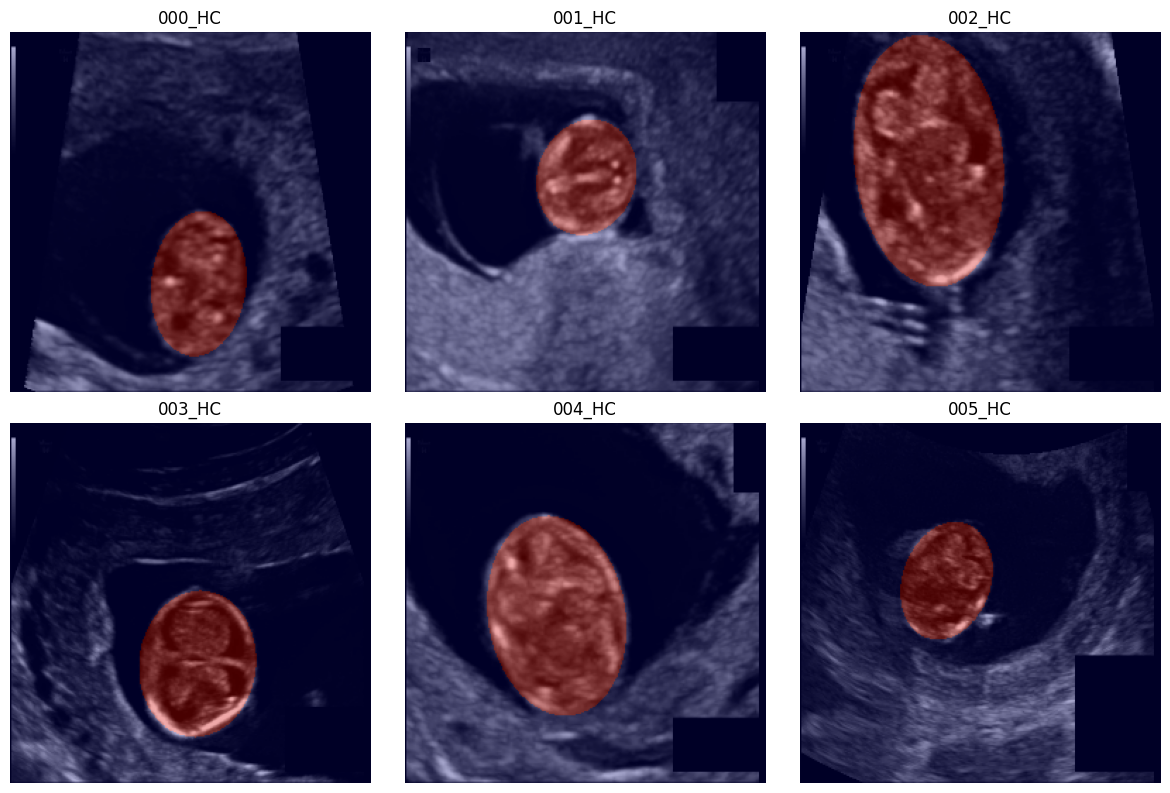

In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path

samples = sorted((OUT/"images").glob("*.png"))[:6]

plt.figure(figsize=(12,8))
for i, p in enumerate(samples, 1):
    m = (OUT/"masks"/p.name)
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(m), cv2.IMREAD_UNCHANGED)
    overlay = cv2.applyColorMap((msk*(255//max(1, msk.max()))).astype(np.uint8), cv2.COLORMAP_JET)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)*0.7 + overlay*0.3
    vis = np.clip(vis, 0, 255).astype(np.uint8)
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(p.stem)
plt.tight_layout(); plt.show()


In [13]:
ROOT = Path("data/paired_256")
IM_DIR, MS_DIR = ROOT/"images", ROOT/"masks"
pairs = [(p, MS_DIR/p.name) for p in sorted(IM_DIR.glob("*.png")) if (MS_DIR/p.name).exists()]

paths = np.array([str(p[0]) for p in pairs])
labels = np.array([Path(p).stem.split("_")[1] if "_" in Path(p).stem else "x" for p in paths])

X_tr, X_tmp, y_tr, y_tmp = train_test_split(paths, labels, test_size=0.4, random_state=SEED, stratify=labels)
X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp)

def subset_pairs(lst):
    s = set(lst.tolist())
    return [(Path(p), MS_DIR/Path(p).name) for p in paths if p in s]

train_pairs = subset_pairs(X_tr)
val_pairs   = subset_pairs(X_va)
test_pairs  = subset_pairs(X_te)

len(train_pairs), len(val_pairs), len(test_pairs)

(2298, 766, 766)

# Аугментация

In [14]:
SIZE = 256

RZ = A.Compose([
    A.Resize(SIZE, SIZE)
])

RC_RZ = A.Compose([
    A.RandomCrop(128, 128, p=1.0),
    A.Resize(SIZE, SIZE)
])

HF = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Resize(SIZE, SIZE)
])

VF = A.Compose([
    A.VerticalFlip(p=0.3),
    A.Resize(SIZE, SIZE)
])

ROT = A.Compose([
    A.Rotate(limit=30, border_mode=cv2.BORDER_REFLECT_101, p=0.3),
    A.Resize(SIZE, SIZE)
])

CMB = A.Compose([
    A.RandomCrop(128, 128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
    A.Resize(SIZE, SIZE)
])

RRC_RZ = A.Compose([
    A.RandomResizedCrop(height=SIZE, width=SIZE, scale=(0.6, 0.8), ratio=(1.0, 1.0), p=1.0),
    A.Resize(SIZE, SIZE)
])

PAD_RC_RZ = A.Compose([
    A.PadIfNeeded(min_height=SIZE+32, min_width=SIZE+32, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    A.RandomCrop(SIZE, SIZE, p=1.0),
    A.Resize(SIZE, SIZE)
])

ADV = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(
        alpha=1.0,
        sigma=50.0,
        alpha_affine=0.0,                       # <-- раньше было 0.0, теперь нужно None
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        p=0.5
    ),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.Resize(SIZE, SIZE, interpolation=cv2.INTER_LINEAR),
])

PIPELINES = {
    "RZ": RZ,
    "RC_RZ": RC_RZ,
    "HF": HF,
    "VF": VF,
    "ROT": ROT,
    "CMB": CMB,
    "RRC_RZ": RRC_RZ,
    "PAD_RC_RZ": PAD_RC_RZ,
    "ADV": ADV,
}

In [17]:
OUT = Path("data/aug")
if OUT.exists(): shutil.rmtree(OUT)
for sub in ["train/images","train/masks","val/images","val/masks","test/images","test/masks"]:
    (OUT/sub).mkdir(parents=True, exist_ok=True)

COPIES = {
    "RZ": 1,
    "RC_RZ": 1,
    "HF": 1,
    "VF": 1,
    "ROT": 1,
    "CMB": 1,
    "RRC_RZ": 1,
    "PAD_RC_RZ": 1,
    "ADV": 2,
}

def read_gray(p):
    x = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if x is None:
        x = cv2.cvtColor(cv2.imread(str(p), cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    return x

def apply_aug(aug, img, msk):
    msk = msk.astype(np.uint8)
    return aug(image=img, mask=msk)

count = 0
for ip, mp in tqdm(train_pairs, desc="augment train"):
    img = read_gray(ip)
    msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
    if msk is None:
        continue
    if msk.ndim == 3:
        msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    for name, aug in PIPELINES.items():
        for k in range(COPIES[name]):
            t = apply_aug(aug, img, msk)
            base = f"{ip.stem}__{name}_{k:02d}.png"
            cv2.imwrite(str(OUT/"train/images"/base), t["image"])
            cv2.imwrite(str(OUT/"train/masks"/base),  t["mask"])
            count += 1

for subset, pairs_ in [("val", val_pairs), ("test", test_pairs)]:
    for ip, mp in tqdm(pairs_, desc=f"prep {subset}"):
        img = read_gray(ip)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        if msk is None:
            continue
        if msk.ndim == 3:
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        t = RZ(image=img, mask=msk)
        base = f"{ip.stem}.png"
        cv2.imwrite(str(OUT/f"{subset}/images"/base), t["image"])
        cv2.imwrite(str(OUT/f"{subset}/masks"/base),  t["mask"])

print("train augmented samples:", count)

prep test: 100%|██████████| 766/766 [00:00<00:00, 903.43it/s]

train augmented samples: 22980


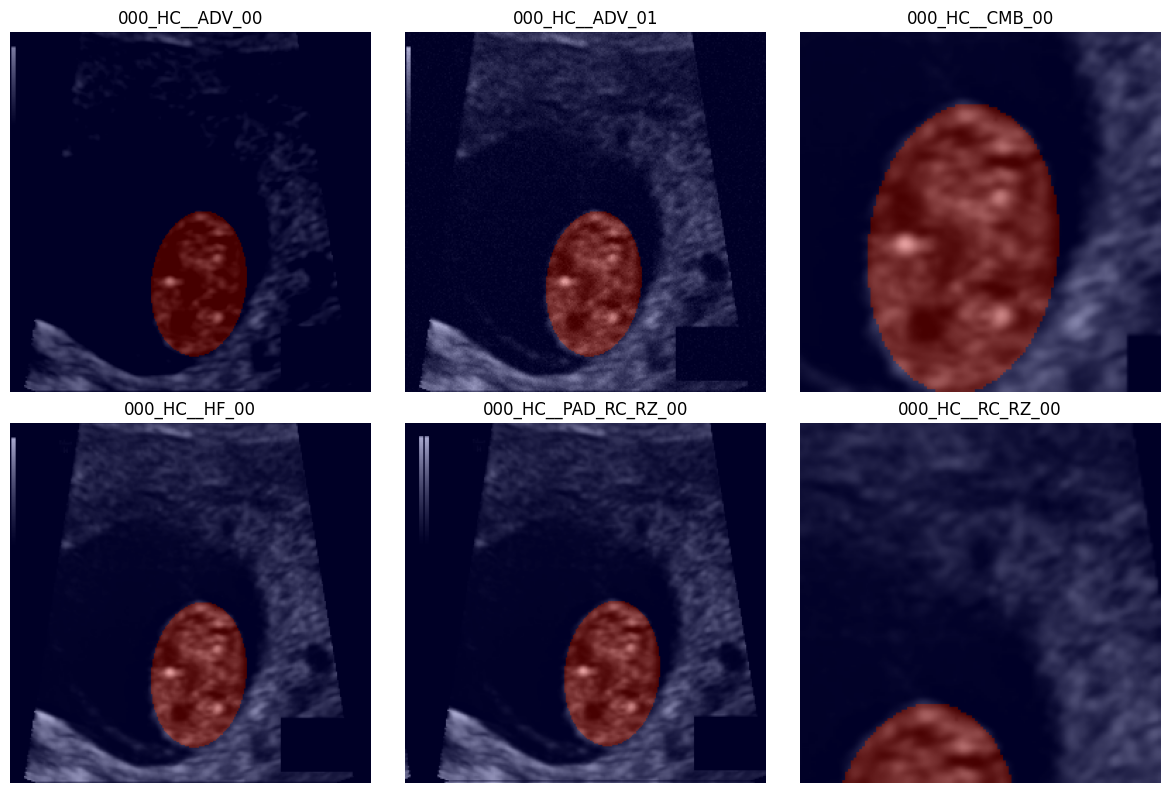

In [22]:
import matplotlib.pyplot as plt

samples = sorted((OUT/"train/images").glob("*.png"))[:6]
plt.figure(figsize=(12,8))
for i, p in enumerate(samples, 1):
    m = (OUT/"train/masks"/p.name)
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(m), cv2.IMREAD_UNCHANGED)
    ov = cv2.applyColorMap((msk*(255//max(1, msk.max()))).astype(np.uint8), cv2.COLORMAP_JET)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)*0.7 + ov*0.3
    vis = np.clip(vis, 0, 255).astype(np.uint8)
    plt.subplot(2,3,i); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(p.stem)
plt.tight_layout(); plt.show()


In [23]:
def count_pairs(folder):
    ims = len(list((folder/"images").glob("*.png")))
    ms  = len(list((folder/"masks").glob("*.png")))
    return {"images": ims, "masks": ms}

stats = {
    "train": count_pairs(OUT/"train"),
    "val":   count_pairs(OUT/"val"),
    "test":  count_pairs(OUT/"test"),
    "seed":  SEED,
    "pipelines": list(PIPELINES.keys()),
    "copies": COPIES,
}
with open(OUT/"manifest.json","w") as f:
    json.dump(stats, f, indent=2)
stats

{'train': {'images': 22980, 'masks': 22980},
 'val': {'images': 766, 'masks': 766},
 'test': {'images': 766, 'masks': 766},
 'seed': 1337,
 'pipelines': ['RZ',
  'RC_RZ',
  'HF',
  'VF',
  'ROT',
  'CMB',
  'RRC_RZ',
  'PAD_RC_RZ',
  'ADV'],
 'copies': {'RZ': 1,
  'RC_RZ': 1,
  'HF': 1,
  'VF': 1,
  'ROT': 1,
  'CMB': 1,
  'RRC_RZ': 1,
  'PAD_RC_RZ': 1,
  'ADV': 2}}

In [24]:
from collections import Counter

In [25]:
MSK_DIR = Path("data/paired_256/masks")
counts = Counter()
for p in MSK_DIR.glob("*.png"):
    m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if m is None: continue
    if m.ndim == 3: m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    vals, cnt = np.unique(m, return_counts=True)
    for v,c in zip(vals, cnt): counts[int(v)] += int(c)
sorted(counts.items())[:20], (min(counts), max(counts))

([(0, 167983001), (38, 77227828), (75, 5403357), (113, 388694)], (0, 113))

EXTRACTING BOUNDING BOXES FROM AUGMENTED DATASET

=== Processing TRAIN ===
Found 22980 image pairs


Processing train: 100%|██████████| 22980/22980 [00:21<00:00, 1054.06it/s]



train statistics:
  Total images: 22980
  Brain : 21831 boxes in 21658 images (94.2%)
  CSP   : 13213 boxes in 13143 images (57.2%)
  LV    :  5820 boxes in  5810 images (25.3%)
  Images with all 3 classes: 4862

=== Processing VAL ===
Found 766 image pairs


Processing val: 100%|██████████| 766/766 [00:00<00:00, 1444.82it/s]



val statistics:
  Total images: 766
  Brain :   717 boxes in   717 images (93.6%)
  CSP   :   452 boxes in   452 images (59.0%)
  LV    :   219 boxes in   219 images (28.6%)
  Images with all 3 classes: 186

=== Processing TEST ===
Found 766 image pairs


Processing test: 100%|██████████| 766/766 [00:00<00:00, 1284.96it/s]



test statistics:
  Total images: 766
  Brain :   721 boxes in   721 images (94.1%)
  CSP   :   462 boxes in   462 images (60.3%)
  LV    :   210 boxes in   210 images (27.4%)
  Images with all 3 classes: 178

OVERALL DATASET STATISTICS

Total images: 24512
  Train: 22980
  Val:   766
  Test:  766

Boxes by class:
  Brain :  23269 boxes in  23096 images
  CSP   :  14127 boxes in  14057 images
  LV    :   6249 boxes in   6239 images

VISUALIZING EXAMPLES

Visualizing 12 examples with all 3 classes from train...


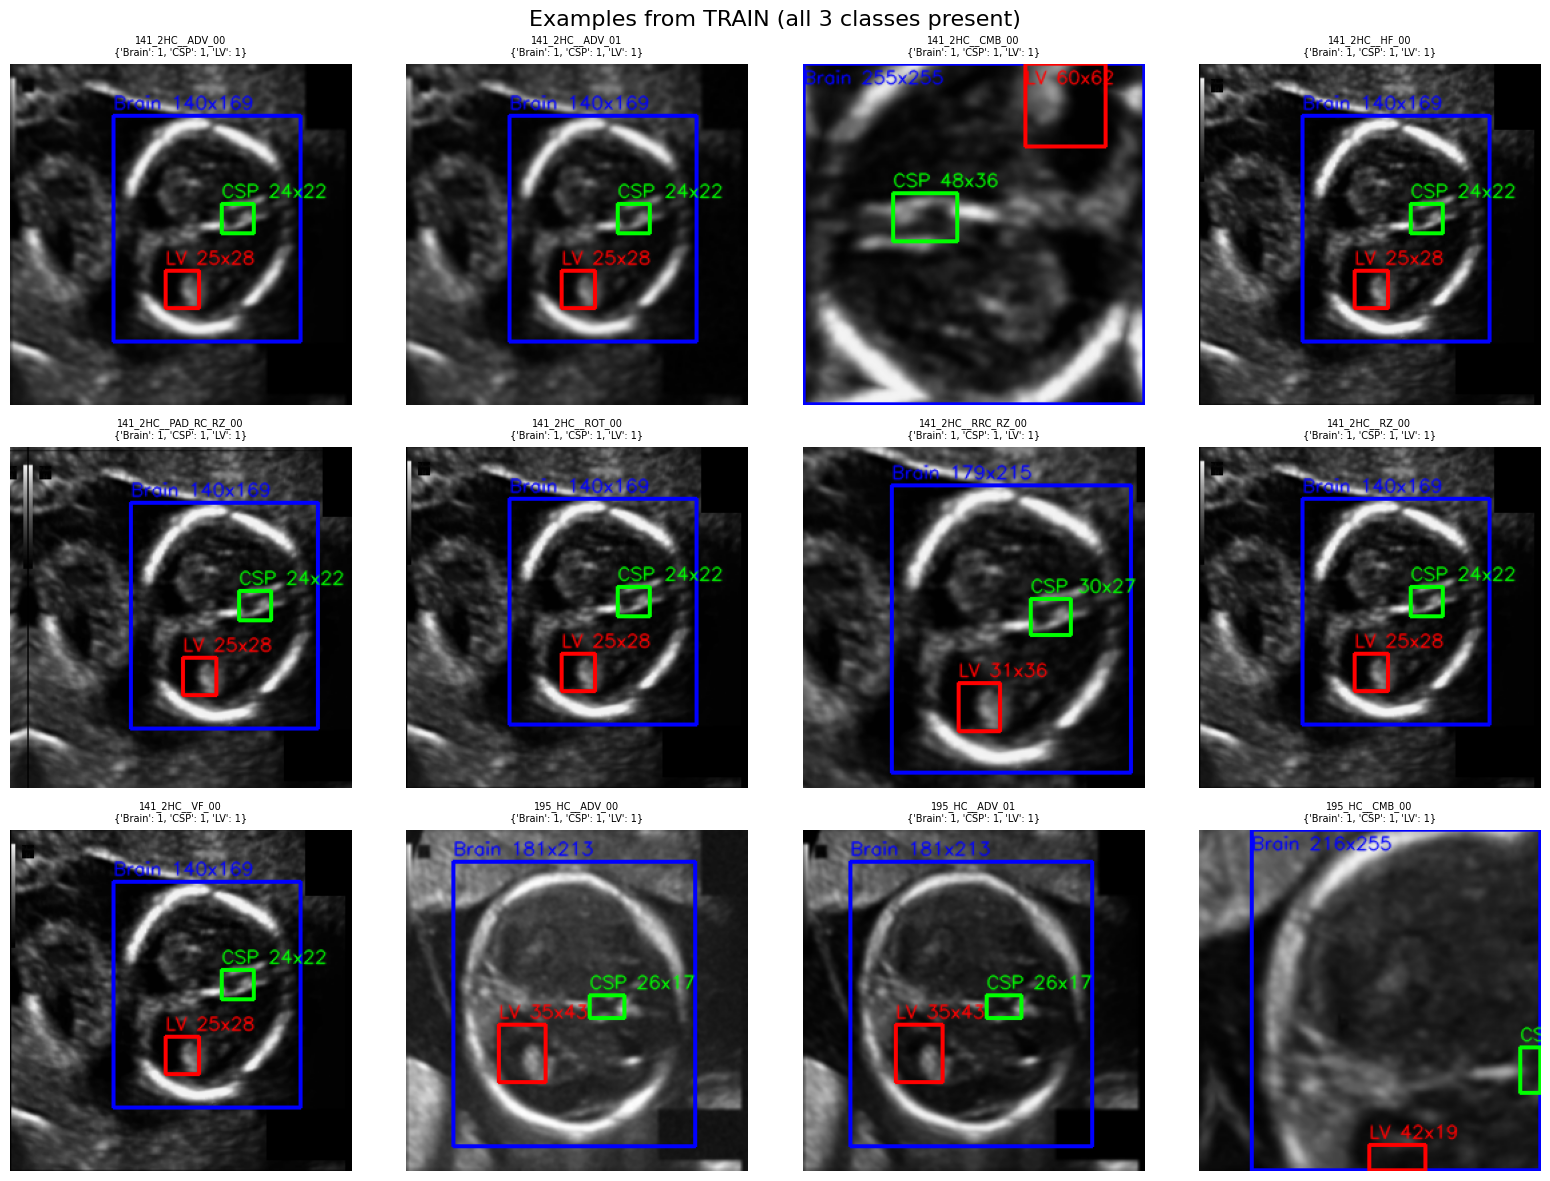

Saved: data/aug_viz/overview_train_all3classes.png

Visualizing 12 examples with all 3 classes from val...


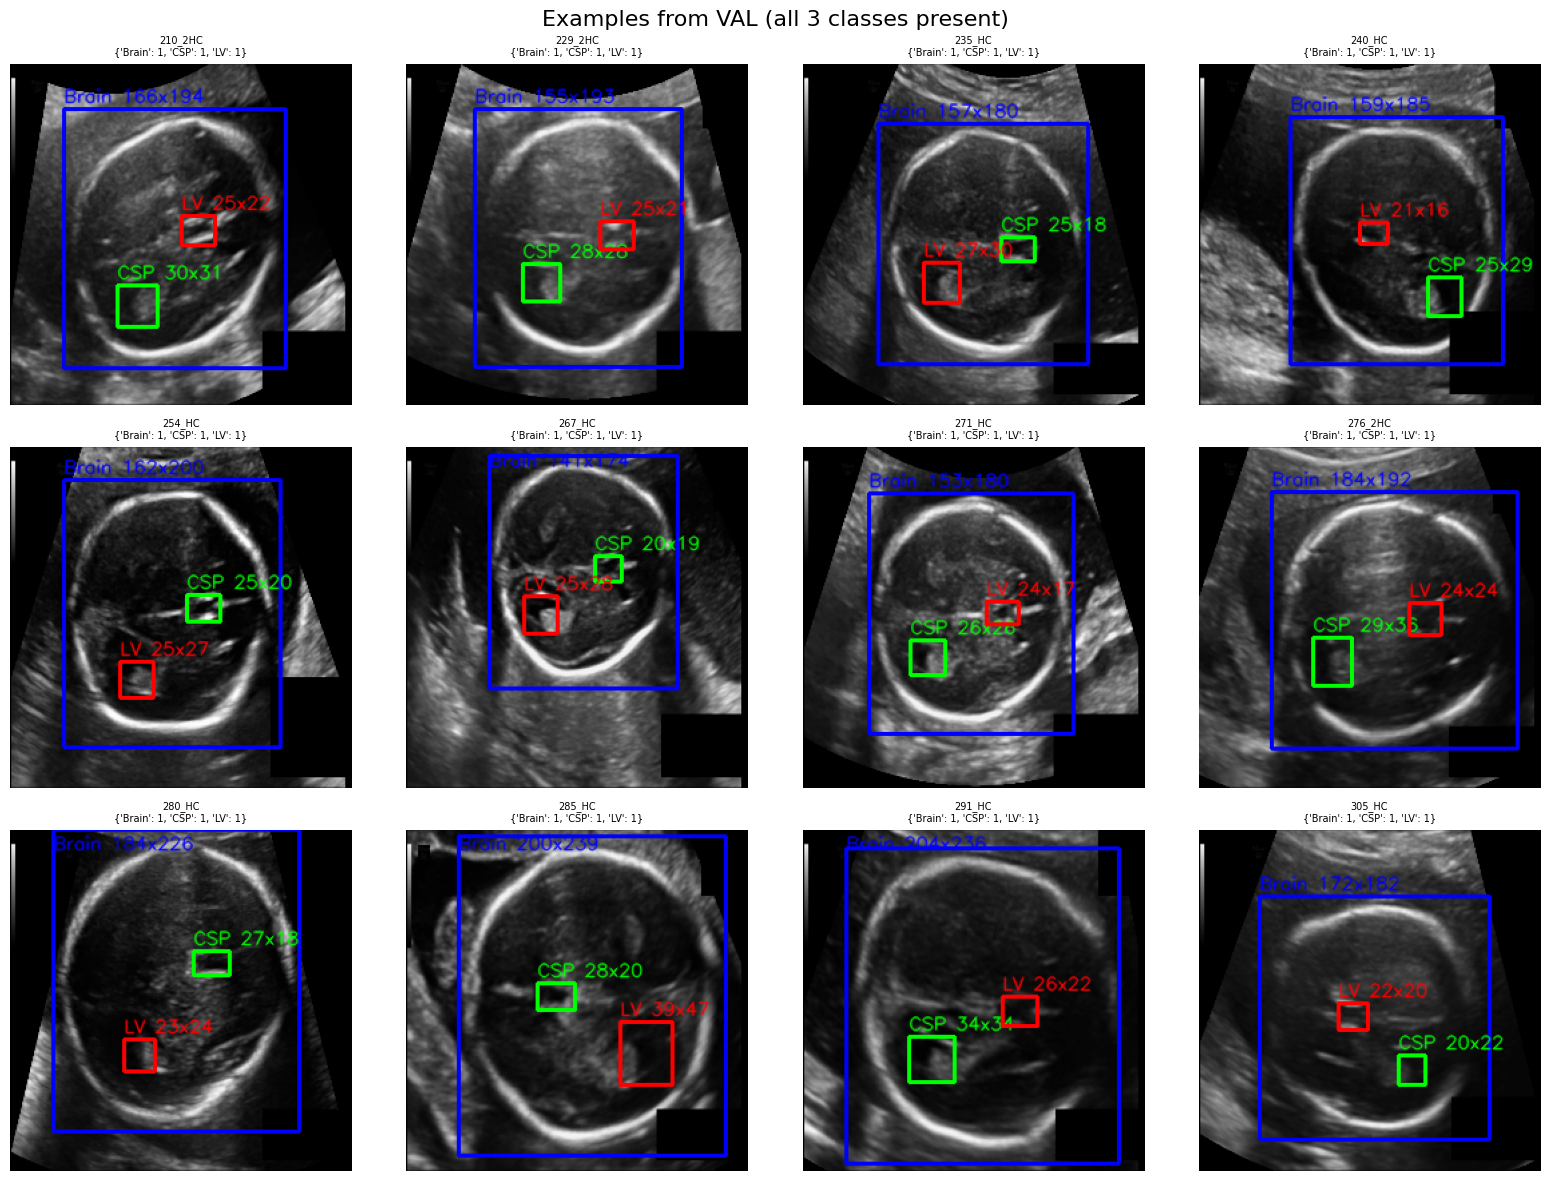

Saved: data/aug_viz/overview_val_all3classes.png

Visualizing 12 examples with all 3 classes from test...


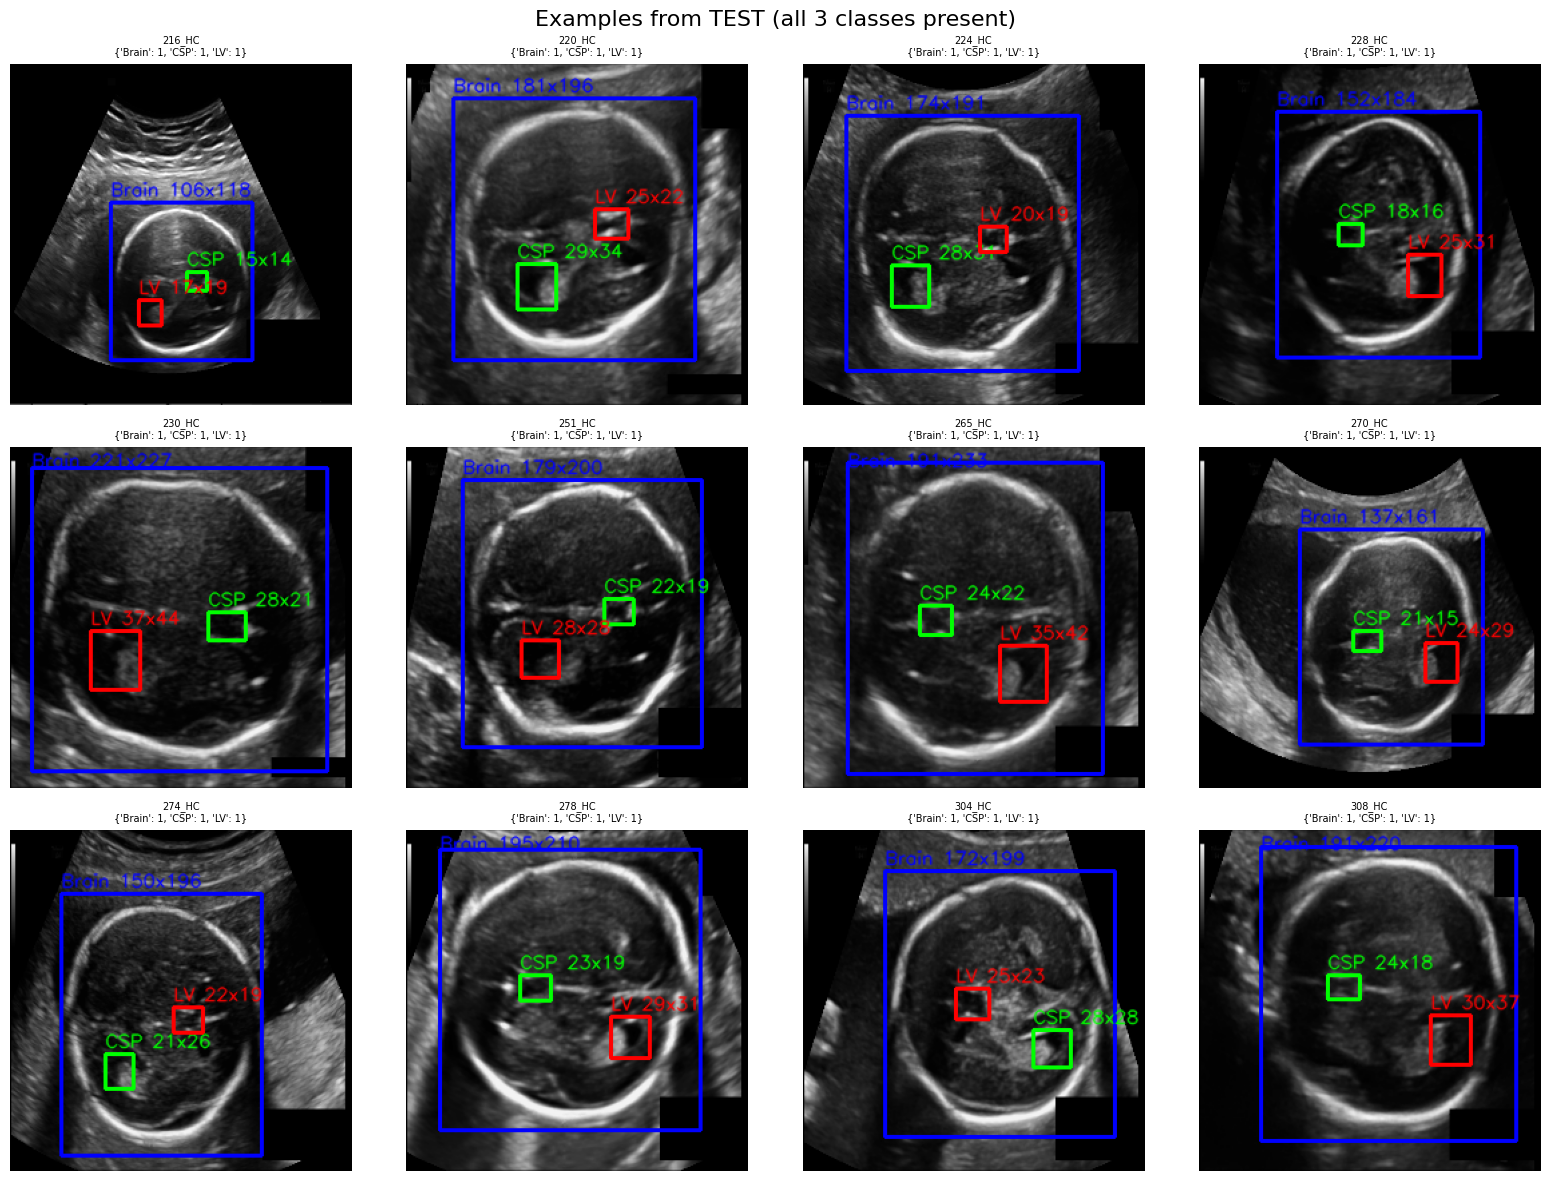

Saved: data/aug_viz/overview_test_all3classes.png

✓ DONE!

Bounding box files saved to: data/aug_bboxes
Visualizations saved to: data/aug_viz

Output data structure:
  data/aug_bboxes/train/*.txt
  data/aug_bboxes/val/*.txt
  data/aug_bboxes/test/*.txt


In [42]:
import os, csv, shutil
from pathlib import Path
import numpy as np, cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional

ROOT = Path("data/aug")
TRAIN_IMG = ROOT / "train/images"
TRAIN_MSK = ROOT / "train/masks"
VAL_IMG = ROOT / "val/images"
VAL_MSK = ROOT / "val/masks"
TEST_IMG = ROOT / "test/images"
TEST_MSK = ROOT / "test/masks"

OUT_ROOT = Path("data/aug_bboxes")
VIZ_ROOT = Path("data/aug_viz")

for split in ["train", "val", "test"]:
    (OUT_ROOT / split).mkdir(parents=True, exist_ok=True)
    (VIZ_ROOT / split).mkdir(parents=True, exist_ok=True)

MIN_AREA_MAP = {
    "Brain": 500,
    "CSP": 10,
    "LV": 10
}
DILATE_ITERS = 1
PAD_RATIO = 0.05
USE_ROTATED = False

CLASSES = {
    "Brain": 0,
    "CSP": 1,
    "LV": 2
}

CLASS_ID_TO_NAME = {
    38: "Brain",
    75: "CSP",
    113: "LV"
}

from dataclasses import dataclass
from typing import List, Tuple, Dict

@dataclass
class Box:
    cls: str
    cx: float; cy: float
    w: float;  h: float
    angle: float = 0.0
    aabb: Tuple[int,int,int,int] = (0,0,0,0)

def _clamp(x, lo, hi):
    return max(lo, min(hi, x))

def _pad_aabb(x1,y1,x2,y2, pad, W, H):
    pw = int(round(pad * (x2-x1)))
    ph = int(round(pad * (y2-y1)))
    x1 = _clamp(x1 - pw, 0, W-1)
    y1 = _clamp(y1 - ph, 0, H-1)
    x2 = _clamp(x2 + pw, 0, W-1)
    y2 = _clamp(y2 + ph, 0, H-1)
    return x1,y1,x2,y2

def mask_to_boxes(mask: np.ndarray,
                  classes: Dict[int,str],
                  min_area_map: Dict[str, int],
                  dilate_iters=0,
                  pad_ratio=0.0,
                  use_rotated=False) -> List[Box]:
    H, W = mask.shape[:2]
    boxes: List[Box] = []
    kernel = np.ones((3,3), np.uint8) if dilate_iters > 0 else None
    
    for cid, cname in classes.items():
        min_area_px = min_area_map.get(cname, 64)
        
        m = (mask == cid).astype(np.uint8) * 255
        if dilate_iters > 0:
            m = cv2.dilate(m, kernel, iterations=dilate_iters)
        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in cnts:
            area = cv2.contourArea(c)
            if area < min_area_px:
                continue
            
            if use_rotated:
                rect = cv2.minAreaRect(c)
                (cx, cy), (w, h), ang = rect
                if w < h:
                    w, h = h, w
                    ang = (ang + 90.0) % 180.0
                box_pts = cv2.boxPoints(((cx,cy),(w,h),ang)).astype(int)
                x1,y1 = box_pts[:,0].min(), box_pts[:,1].min()
                x2,y2 = box_pts[:,0].max(), box_pts[:,1].max()
                x1,y1,x2,y2 = _pad_aabb(x1,y1,x2,y2, pad_ratio, W, H)
                boxes.append(Box(cname, float(cx), float(cy), float(w), float(h), float(ang), (x1,y1,x2,y2)))
            else:
                x,y,w,h = cv2.boundingRect(c)
                x1,y1,x2,y2 = _pad_aabb(x, y, x+w, y+h, pad_ratio, W, H)
                cx = (x1 + x2) / 2.0
                cy = (y1 + y2) / 2.0
                boxes.append(Box(cname, cx, cy, x2-x1, y2-y1, 0.0, (x1,y1,x2,y2)))
    
    return boxes

def write_bbox_txt(txt_path: Path, boxes: List[Box], img_w: int, img_h: int, cls_map: Dict[str,int]):
    with open(txt_path, "w") as f:
        for b in boxes:
            if b.cls not in cls_map:
                continue
            cxn = b.cx / img_w
            cyn = b.cy / img_h
            wn  = b.w  / img_w
            hn  = b.h  / img_h
            f.write(f"{cls_map[b.cls]} {cxn:.6f} {cyn:.6f} {wn:.6f} {hn:.6f}\n")

def draw_boxes_bgr(img_bgr: np.ndarray, boxes: List[Box]) -> np.ndarray:
    out = img_bgr.copy()
    class_colors = {
        "Brain": (255, 0, 0),
        "CSP": (0, 255, 0),
        "LV": (0, 0, 255)
    }
    
    for b in boxes:
        color = class_colors.get(b.cls, (255, 255, 0))
        x1,y1,x2,y2 = b.aabb
        cv2.rectangle(out, (x1,y1), (x2,y2), color, 2)
        cv2.putText(out, f"{b.cls} {int(b.w)}x{int(b.h)}", (x1, max(15, y1-5)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
    return out

def process_split(split_name, img_dir, msk_dir, out_dir, viz_dir):
    print(f"\n=== Processing {split_name.upper()} ===")
    
    img_files = sorted(img_dir.glob("*.png"))
    msk_files = sorted(msk_dir.glob("*.png"))
    
    pairs = []
    for img_path in img_files:
        msk_path = msk_dir / img_path.name
        if msk_path.exists():
            pairs.append((img_path, msk_path))
    
    print(f"Found {len(pairs)} image pairs")
    
    stats = {"Brain": 0, "CSP": 0, "LV": 0}
    images_with_class = {"Brain": 0, "CSP": 0, "LV": 0}
    pairs_with_all_classes = []
    
    for ip, mp in tqdm(pairs, desc=f"Processing {split_name}"):
        img = cv2.imread(str(ip), cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        
        if img is None or msk is None:
            continue
        
        if msk.ndim == 3:
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        
        H, W = img.shape[:2]
        
        boxes = mask_to_boxes(msk, CLASS_ID_TO_NAME, MIN_AREA_MAP, 
                             DILATE_ITERS, PAD_RATIO, USE_ROTATED)
        
        txt_path = out_dir / f"{ip.stem}.txt"
        write_bbox_txt(txt_path, boxes, W, H, CLASSES)
        
        img_classes = set()
        for b in boxes:
            stats[b.cls] += 1
            img_classes.add(b.cls)
        
        for cls in img_classes:
            images_with_class[cls] += 1
        
        if len(img_classes) == 3:
            pairs_with_all_classes.append((ip, mp))
    
    print(f"\n{split_name} statistics:")
    print(f"  Total images: {len(pairs)}")
    for cls in ["Brain", "CSP", "LV"]:
        pct = (images_with_class[cls] / len(pairs) * 100) if len(pairs) > 0 else 0
        print(f"  {cls:6s}: {stats[cls]:5d} boxes in {images_with_class[cls]:5d} images ({pct:.1f}%)")
    print(f"  Images with all 3 classes: {len(pairs_with_all_classes)}")
    
    return pairs, pairs_with_all_classes, stats, images_with_class

print("=" * 60)
print("EXTRACTING BOUNDING BOXES FROM AUGMENTED DATASET")
print("=" * 60)

train_pairs, train_all3, train_stats, train_img_stats = process_split(
    "train", TRAIN_IMG, TRAIN_MSK, OUT_ROOT/"train", VIZ_ROOT/"train"
)

val_pairs, val_all3, val_stats, val_img_stats = process_split(
    "val", VAL_IMG, VAL_MSK, OUT_ROOT/"val", VIZ_ROOT/"val"
)

test_pairs, test_all3, test_stats, test_img_stats = process_split(
    "test", TEST_IMG, TEST_MSK, OUT_ROOT/"test", VIZ_ROOT/"test"
)

print("\n" + "=" * 60)
print("OVERALL DATASET STATISTICS")
print("=" * 60)

total_images = len(train_pairs) + len(val_pairs) + len(test_pairs)
print(f"\nTotal images: {total_images}")
print(f"  Train: {len(train_pairs)}")
print(f"  Val:   {len(val_pairs)}")
print(f"  Test:  {len(test_pairs)}")

print("\nBoxes by class:")
for cls in ["Brain", "CSP", "LV"]:
    total_boxes = train_stats[cls] + val_stats[cls] + test_stats[cls]
    total_imgs = train_img_stats[cls] + val_img_stats[cls] + test_img_stats[cls]
    print(f"  {cls:6s}: {total_boxes:6d} boxes in {total_imgs:6d} images")

print("\n" + "=" * 60)
print("VISUALIZING EXAMPLES")
print("=" * 60)

def visualize_samples_with_all_classes(pairs_all3, split_name, num_samples=12):
    print(f"\nVisualizing {num_samples} examples with all 3 classes from {split_name}...")
    
    if len(pairs_all3) == 0:
        print(f"No images with all 3 classes found in {split_name}")
        return
    
    samples = pairs_all3[:num_samples]
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Examples from {split_name.upper()} (all 3 classes present)', fontsize=16)
    
    for idx, (ip, mp) in enumerate(samples):
        if idx >= num_samples:
            break
            
        img = cv2.imread(str(ip), cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
        
        if img is None or msk is None:
            continue
        
        if msk.ndim == 3:
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        
        boxes = mask_to_boxes(msk, CLASS_ID_TO_NAME, MIN_AREA_MAP, 
                             DILATE_ITERS, PAD_RATIO, USE_ROTATED)
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        vis = draw_boxes_bgr(vis, boxes)
        
        class_counts = {}
        for b in boxes:
            class_counts[b.cls] = class_counts.get(b.cls, 0) + 1
        
        row, col = idx // 4, idx % 4
        axes[row, col].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(f"{ip.stem[:30]}\n{class_counts}", fontsize=7)
        axes[row, col].axis('off')
    
    for idx in range(len(samples), 12):
        row, col = idx // 4, idx % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    out_path = VIZ_ROOT / f"overview_{split_name}_all3classes.png"
    plt.savefig(str(out_path), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {out_path}")

visualize_samples_with_all_classes(train_all3, "train", 12)
visualize_samples_with_all_classes(val_all3, "val", 12)
visualize_samples_with_all_classes(test_all3, "test", 12)

print("\n" + "=" * 60)
print("✓ DONE!")
print("=" * 60)
print(f"\nBounding box files saved to: {OUT_ROOT}")
print(f"Visualizations saved to: {VIZ_ROOT}")
print("\nOutput data structure:")
print(f"  {OUT_ROOT}/train/*.txt")
print(f"  {OUT_ROOT}/val/*.txt")
print(f"  {OUT_ROOT}/test/*.txt")

In [29]:
from pathlib import Path
import numpy as np, cv2, json

TRAIN_MASK_DIRS = [
    Path("data/aug/train/masks"),и
    Path("data/paired_256/masks"), 
]
mask_dir = next((p for p in TRAIN_MASK_DIRS if p.exists()), None)

VALUE_TO_ID = {0:0, 38:1, 75:2, 113:3}
NCLASSES = 4

def remap_mask_to_ids(mask):
    out = np.zeros_like(mask, dtype=np.uint8)
    for v,i in VALUE_TO_ID.items():
        out[mask==v] = i
    return out


In [30]:
from collections import Counter

class_counts = np.zeros(NCLASSES, dtype=np.int64)

mask_paths = sorted(mask_dir.glob("*.png"))
for p in mask_paths:
    m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if m is None:
        continue
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    m = remap_mask_to_ids(m)
    uniq, cnt = np.unique(m, return_counts=True)
    class_counts[uniq] += cnt

class_counts[class_counts == 0] = 1
class_counts


array([900800613, 564306150,  37828788,   3081729])

In [31]:
min_w, max_w = 0.1, 0.9

total = class_counts.sum()
raw = total / class_counts.astype(np.float64)
raw = raw / raw.sum()

mn, mx = raw.min(), raw.max()
if mx > mn:
    weights = (raw - mn) / (mx - mn) * (max_w - min_w) + min_w
else:
    weights = np.full_like(raw, (min_w + max_w)/2.0)

weights_list = weights.tolist()
weights_list


[0.1, 0.10163759766444325, 0.1626495940082151, 0.9]

In [32]:
out = {
    "class_counts": class_counts.tolist(),
    "weights": weights_list,
    "value_to_id": VALUE_TO_ID,
    "range": [min_w, max_w],
}
Path("data/weights").mkdir(parents=True, exist_ok=True)
with open("data/weights/class_weights.json","w") as f:
    json.dump(out, f, indent=2)

try:
    import torch
    torch_weights = torch.tensor(weights_list, dtype=torch.float32)
    torch_weights
except Exception as e:
    print("torch недоступен:", e)


In [33]:
%pip -q uninstall -y torch torchvision torchaudio
%pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))

torch: 2.5.1+cu121
cuda available: True
device count: 1
device name: NVIDIA GeForce RTX 4090
